Text(0, 0.5, 'CHSH witness')

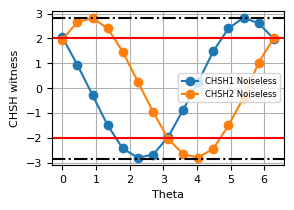

In [26]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

# Set backend device, choose to use a simulator
sim = Aer.get_backend('aer_simulator')


# functions..............................................................................................
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one circuit for each value of theta in theta_vec)
    (theta is the angle between the bases of Alice and Bob)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11'] # observed_vector? ex: '01' means 1st measurement got 0, second got 1
        for el in obs_vec:
            qc = QuantumCircuit(2,2) # create a quantum circuit with two quantum register(qubits) and two classical register
            qc.h(0) # add a H gate on qubit 0
            qc.cx(0, 1) # Add a CX (CNOT) gate on control qubit 0 and target qubit 1
            qc.ry(theta, 0) # rotate around y-axis by theta
            for a in range(2): # what does this do? why do we need this part?
                if el[a] == '1':
                    qc.h(a)
            qc.measure(range(2),range(2)) # measure q0 save to bit_0, then measure q1 save to bit_1
            chsh_circuits.append(qc)

    return chsh_circuits

def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 dicts per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses (the values of "S")
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = [] # this is the final "S" value
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2
# functions...........................................................................................


#split 0 to 2pi into 15 angles. use these angles to build the chsh circuit
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

# test and see the circuit: the circuits create a bell pair, and measure them in different basis. 
# Bob(q1) in +,-,0,1 state, Alice(q0) in theta respected to Bob
# my_chsh_circuits[5].draw()

# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())

# make plot
plt.figure(figsize=(3,2))
plt.rcParams.update({'font.size': 8})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 6})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')